In [ ]:
using Pkg 
Pkg.activate("../")
#Pkg.add(["PyPlot", "Printf", "LinearAlgebra", "Flux", "DiffEqFlux", "Optim", "SciMLSensitivity", "OrdinaryDiffEq", "ComponentArrays", "Random", "OptimizationOptimisers", "OptimizationOptimJL", "Optimization", "BSON"])
using Plots:mm
using Printf
using LinearAlgebra
using Flux, DiffEqFlux, Optim, SciMLSensitivity
using OrdinaryDiffEq
using ComponentArrays
using Random
using BSON: @save, @load
using Optimization, OptimizationOptimJL, OptimizationOptimisers

  Activating project at `e:\coding\scientific-ml`


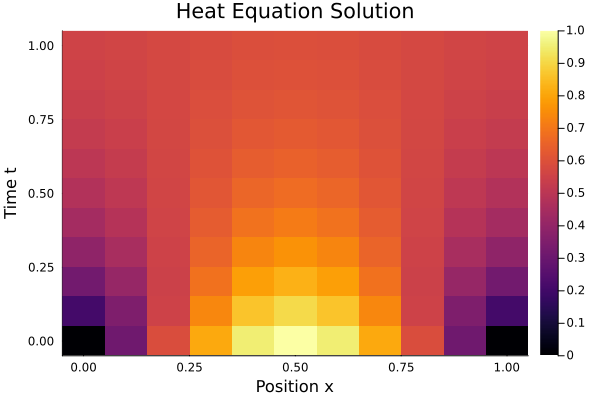

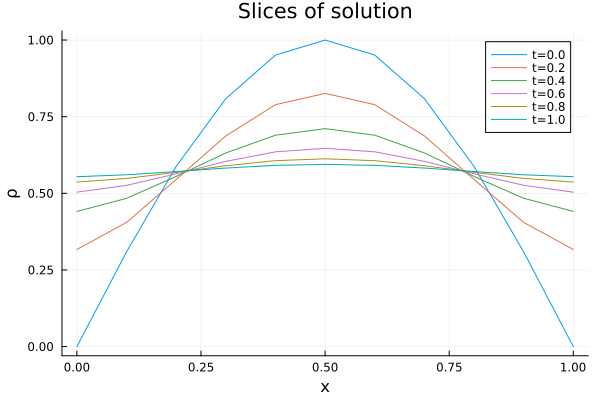

In [51]:
# 1. Generating synthetic ground truth data 
using Plots
using Printf
using LinearAlgebra
using OrdinaryDiffEq

# Initializing parameters
D = 0.1 # diffusion constant for generating ground truth data
X = 1.0 # this is the max len of rod 
T = 1.0 # this is the max time till which we want to simulate 
dx = X/10 # this is the step size as we go from 0 to X 
dt = T/10 # this is the step size as we go from 0 to T 
nx = Int64(X/dx + 1) # this is the number of points from 0 to X in dx step size. 1/0.01=100 x points 
nt = Int64(T/dt + 1) # this is the number of points from 0 to T in dt step size. 1/0.10=10 t points 
x = collect(0:dx:X) # this is the actual collection of points from 0 to X with dx step size 
t = collect(0:dt:T) # this is the actual collection of points from 0 to T with dt step size
# multiply x by π to each point and then apply sin function. This is the initial temperature at all points
# on the rod at time t=0
ρ0 = sin.(pi.*x) # this would give something like [sin(π*x1), sin(π*x2),..., sin(π*xn)]

# now we will generate the space gradient d²ρ/dx² (called laplacian operator). We need a laplacian matrix 
# to compute the space gradient because we are calculating this gradient numerically at each point by
# discretizing the space and approximating second derivative at each point using finite differences. This is 
# for ground truth data only, that is why we consider the kernel to be [1,-2,1] (hence the laplacian matrix)
# we will train our ude model to be able to predict the kernel was learnable parameters [w1,w2,w3]

# Fix the laplacian matrix construction
lap = diagm(0 => -2.0*ones(nx), # Main diagonal should be -2
            1 => 1.0*ones(nx-1),  # Upper diagonal
            -1 => 1.0*ones(nx-1)) / dx^2  # Lower diagonal

# Apply boundary conditions (periodic or zero flux)
lap[1,end] = 1.0/dx^2 
lap[end,1] = 1.0/dx^2 

# Define the heat equation RHS
function heat_rhs!(drho, rho, p, t)
    drho .= D * (lap * rho)
end

# Set up and solve the ODE problem
prob_true = ODEProblem(heat_rhs!, ρ0, (0.0, T))
sol_true = solve(prob_true, Tsit5(); saveat=dt, abstol=1e-6, reltol=1e-6)

# Convert solution to array format
sol_array = Array(sol_true)

# Create heatmap
p1 = heatmap(x, t, sol_array'; 
             xlabel="Position x", 
             ylabel="Time t", 
             title="Heat Equation Solution", 
             colorbar=true)

display(p1)

# Plot multiple slices (every 2nd time step)
plt = plot()  # initialize empty plot
# why are we looping? - for each time point (0,1,2....nt), we are plotting how temperature varies with x
for i in 1:2:nt # plotting through timestamps 0,2,4....tn (steps of two) till nt (tot number of time points)
    # we are passing in plt inside plot to let julia know that we are adding to the plot named plt and not any other plot fn 
    # that could be present somewhere else in the code. 
    # sol_arr[:,i] means temperature at time i (take all spatial points(all rows) for a time point(ith column)) 
    plot!(plt, x, sol_array[:, i], label="t=$(round(sol_true.t[i], digits=2))") 
end

# Set axis labels and title
xlabel!("x")
ylabel!(raw"\rho")
title!("Slices of solution")

# Optional: move legend to upper left outside plot
#plot!(plt, legend=:outertopleft, legendfontsize=7)

In [52]:
# 2. Building the NN 

# we will first initialise the kernel with some random values 
init_w = reshape([1.1, -2.5, 1.0], (3,1,1,1)) # takes a 1D array of 3 elements and reshapes it into a 4D tensor with shape (3, 1, 1, 1).
# In Flux.jl (like in most deep learning libraries), convolutional filters for Conv layers are stored as 4D arrays, with shape:
# (kernel_size..., in_channels, out_channels, dummy dim required by flux) 
cnn = Flux.Conv(init_w, [0.0], pad=(0,0,0,0)) # no padding on either side (left,right,top,bottom) and no bias so 0.0
p1,re1 = Flux.destructure(cnn) # p1 -> gives a vector of parameters of this NN (w1,w2,w3 here) and re1 -> reconstruction fn 
# re1 will let you build the model with updated parameters new_model = re1(new_param_vector)
println(p1)
init_D = [0.0] # it is a 1d array instead of a scaler because we will append it to p1 init_p or initial params array and julia 
# requires compatible types for concatination
init_p = [p1; init_D] # init_p is a single inital parameters vector with initial weights of NN with initial diffusion factor value D 

# custom function to rebuild the model from a single vector pvec 
function reconstruct_cnn(pvec)
    cnn_len = length(p1)
    # Use the reconstruction function re1 to recover the CNN (Flux.Conv) from the first cnn_len elements.
    cnn = re1(pvec[1:cnn_len])
    D = pvec[end] # since we appended init_D to the end of array init_p, D_init is the last value 
    return cnn, D
    # w1 = pvec[1]  # 1.15
    # w2 = pvec[2]  # -2.5  
    # w3 = pvec[3]  # 1.1
    # bias = pvec[4]  # 0.0
    # D = pvec[5]   # 0.0 (this looks concerning - D should be ~0.1)
    
    # return [w1, w2, w3], bias, D
end

[1.1, -2.5, 1.0, 0.0]


reconstruct_cnn (generic function with 1 method)

In [53]:
# 3. now completing the diff eqn using predicted D and stencil 

function ude!(drho, rho, p, t) 
    cnn,D = reconstruct_cnn(p) 
    w1,w2,w3=cnn.weight[:] # cnn.weight is a 4d array of CNN weights -> weight[:] converts it to a 1D vectors, then we extract w1,w2,w3
    # Loop over the spatial grid points 
    @inbounds for i in 1:nx
        # when doing kernel operation, left (T_i-1) and right (T_i+1) terms are multiplied by 1 
        # assuming the cyclic property of rod, left term of 1st spatial term would be Tn, right->T1
        left  = (i == 1)  ? nx : (i - 1)
        right = (i == nx) ? 1  : (i + 1)
        drho[i] =  D * (w1*rho[left] + w2*rho[i] + w3*rho[right]) / (dx^2)
    end 
end 
#     weights, bias, D = reconstruct_cnn(p)
#     w1, w2, w3 = weights
    
#     for i in 1:nx
#         left = (i == 1) ? nx : (i - 1)
#         right = (i == nx) ? 1 : (i + 1)
#         drho[i] = D * (w1*rho[left] + w2*rho[i] + w3*rho[right]) / (dx^2)
#     end
# end




ude! (generic function with 1 method)

In [54]:
# 4. prediction and loss

prob_ude = ODEProblem(ude!, ρ0, (0.0, T), init_p) 

# during training (e.g., when optimizing with Adam), p keeps changing at every step — you always want to
# solve the ODE using the current parameter guess. hence p=curr_p
function predict_ude(curr_p)
    sol = solve(prob_ude, Tsit5();
                p=curr_p, dtmax=dt, saveat=t,
                # when we wrote the line sensealg=InterpolatingAdjoint(...), we are basically telling the solver this: 
                # "Hey, when Zygote comes through and wants to take gradients of this ODE solve call, use the adjoint
                # sensitivity method instead of letting Zygote naively trace everything."
                sensealg=InterpolatingAdjoint(autojacvec=ReverseDiffVJP()), 
                
                # When solving ODEs numerically, you're not getting exact solutions you're getting approximations.
                # absolute and relative tolerance define how much error you're willing to allow in the computed
                # solution at each step.
                abstol=1e-9, reltol=1e-9, maxiters=1e6)
    Array(sol)
end

function loss_ude(curr_p)
    pred = predict_ude(curr_p) # the predict_ude function is used inside loss_ude function only 
    cnn, D = reconstruct_cnn(curr_p)
    w = cnn.weight[:]
    #w, bias, D = reconstruct_cnn(curr_p)
    
    # penalize the diffusion factor for being far from 0.1 / penalize if difference between D and 0.1 is huge 
    D_penalty = 500 * relu(D - 0.1)^2 
    # we also penalize if the predicted weights w1,w2,w3 do not sum up to 0 -> comes from conservation of mass 
    kernel_penalty = 100 * abs(sum(w))

    return sum(abs2, sol_array .- pred) + kernel_penalty + D_penalty
end

function loss_nn_adam(p, args...)
    loss_ude(p)
end

train_losses = Float64[]
epoch_count = 0

# This callback fn will be called in each iteration/epoch
function mycallback(state, l; doplot=true) # state - object that optimizer gives that stores the curr params
    global epoch_count
    push!(train_losses, l)
    curr_p = state.u
    # In each iteration of optimization, we also display the currently optimized parameters - D and weights
    cnn, D = reconstruct_cnn(curr_p)
    w = cnn.weight[:]
    #w, bias, D = reconstruct_cnn(curr_p)
    @info "Epoch = $epoch_count | Loss = $l | D0 = $D | w= $w | sum(w)= $(sum(w))"
    epoch_count += 1
    # The return value of the callback tells the optimizer whether to continue or stop.
    # return false → Keep optimizing (default behavior).
    # return true → Stop optimization early, even if maxiters hasn’t been reached.
    return false
end

mycallback (generic function with 1 method)

In [55]:
rng = Xoshiro(42)
p0 = copy(init_p)


adtype = Optimization.AutoZygote()
optf_adam = Optimization.OptimizationFunction(loss_nn_adam, adtype)
optprob_adam = Optimization.OptimizationProblem(optf_adam, p0)

res_adam = Optimization.solve(
    optprob_adam,
    OptimizationOptimisers.Adam(0.01);
    maxiters=200,
    # “After every epoch, call this function and give it the current optimizer state and current loss.”
    callback = (state, L)->mycallback(state, L; doplot=false)
)

┌ Info: Epoch = 0 | Loss = 48.4180545953549 | D0 = 0.0 | w= [1.1, -2.5, 1.0] | sum(w)= -0.3999999999999999
└ @ Main e:\coding\scientific-ml\ude-heat-eqn\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:52
┌ Info: Epoch = 1 | Loss = 41.159188498609396 | D0 = 0.009999999999900817 | w= [1.109999999999, -2.490000000001, 1.009999999999] | sum(w)= -0.37000000000299993
└ @ Main e:\coding\scientific-ml\ude-heat-eqn\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:52
┌ Info: Epoch = 2 | Loss = 38.34765889228638 | D0 = 0.017118464742840706 | w= [1.1200069151106675, -2.4799943624058143, 1.0200069876136872] | sum(w)= -0.3399804596814595
└ @ Main e:\coding\scientific-ml\ude-heat-eqn\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:52
┌ Info: Epoch = 3 | Loss = 35.66221152855967 | D0 = 0.021705345443175147 | w= [1.130034243454142, -2.469968050381098, 1.030034454640291] | sum(w)= -0.3098993522866651
└ @ Main e:\coding\scientific-ml\ude-heat-eqn\jl_noteb

retcode: Default
u: 5-element Vector{Float64}:
  1.233065376987188
 -2.3682815160285164
  1.1357179456707778
  0.0
  0.07745311449383989

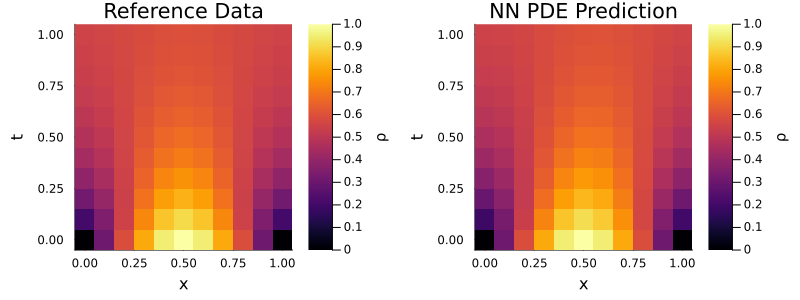

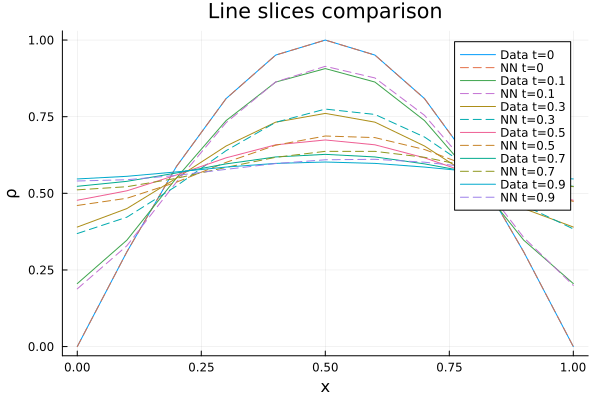

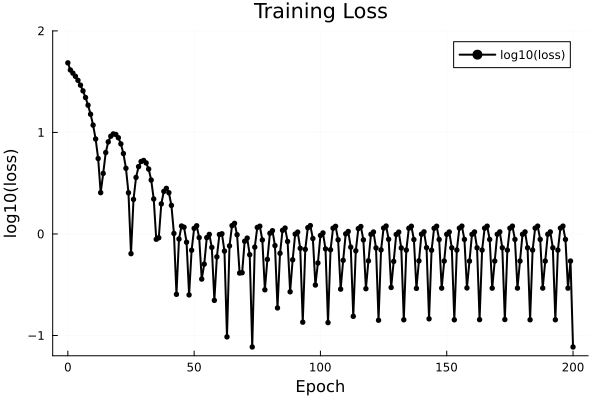

In [56]:
# 6. Final plots 

# p_star -> optimized weights and D 
p_star = res_adam.u 
pred = predict_ude(p_star)

# heatmaps
p1 = heatmap(x, t, sol_array', xlabel="x", ylabel="t", title="Reference Data", colorbar_title="ρ")
p2 = heatmap(x, t, pred', xlabel="x", ylabel="t", title="NN PDE Prediction", colorbar_title="ρ")

plot_combined = plot(p1, p2, layout=(1, 2), size=(800, 300), bottom_margin=5mm, left_margin=5mm)
display(plot_combined)  # ← Add this line

# line slices
p3 = plot(x, sol_array[:,1], label="Data t=0")
plot!(p3, x, pred[:,1], linestyle=:dash, label="NN t=0")

for i in 2:2:nt
    plot!(p3, x, sol_array[:,i], label="Data t=$(round(t[i], digits=1))")
    plot!(p3, x, pred[:,i], linestyle=:dash, label="NN t=$(round(t[i], digits=1))")
end

xlabel!("x")
ylabel!("ρ")  # Fixed LaTeX issue
title!("Line slices comparison")
#legend!()
display(p3)  # ← Add this line

# Loss Curve
# Loss Curve with specific scale to match reference
p4 = plot(0:length(train_losses)-1, log10.(train_losses), 
    label="log10(loss)", 
    marker=:circle, 
    line=:solid, 
    color=:black,
    xlabel="Epoch", 
    ylabel="log10(loss)", 
    title="Training Loss",
    ylims=(-1.2, 2.0),  # Set y-axis range to match reference
    grid=true,          # Show grid lines
    gridwidth=1,        # Grid line thickness
    gridcolor=:lightgray, # Grid color
    markersize=3,       # Circle marker size
    linewidth=2)        # Line thickness 

display(p4)
